## Setup & Data Loading

In [143]:
# Test imports one at a time
print("Importing pandas...")
import pandas as pd
print(f"✓ pandas {pd.__version__}")

print("Importing numpy...")
import numpy as np
print(f"✓ numpy {np.__version__}")

print("Importing matplotlib...")
import matplotlib.pyplot as plt
print("✓ matplotlib")

print("Importing seaborn...")
import seaborn as sns
print("✓ seaborn")

print("Importing nflreadpy...")
import nflreadpy
print(f"✓ nflreadpy {nflreadpy.__version__}")

print("\nImporting sklearn components...")
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
print("✓ sklearn")

print("Importing scipy...")
from scipy import stats
print("✓ scipy")

# Visualization config
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['figure.dpi'] = 100

print("\n✅ All libraries loaded successfully!")


Importing pandas...
✓ pandas 2.3.3
Importing numpy...
✓ numpy 2.3.5
Importing matplotlib...
✓ matplotlib
Importing seaborn...
✓ seaborn
Importing nflreadpy...
✓ nflreadpy 0.1.5

Importing sklearn components...
✓ sklearn
Importing scipy...
✓ scipy

✅ All libraries loaded successfully!


In [144]:
# Load 2010-2025 play-by-play data
seasons = range(2010, 2026)
pbp_list = []

for season in seasons:
    print(f"Loading {season} season...")
    pbp_season = nflreadpy.load_pbp(season).to_pandas()
    pbp_list.append(pbp_season)

pbp = pd.concat(pbp_list, ignore_index=True)
print(f"\nTotal plays loaded: {len(pbp):,}")

Loading 2010 season...
Loading 2011 season...
Loading 2012 season...
Loading 2011 season...
Loading 2012 season...
Loading 2013 season...
Loading 2013 season...
Loading 2014 season...
Loading 2014 season...
Loading 2015 season...
Loading 2015 season...
Loading 2016 season...
Loading 2016 season...
Loading 2017 season...
Loading 2017 season...
Loading 2018 season...
Loading 2018 season...
Loading 2019 season...
Loading 2019 season...
Loading 2020 season...
Loading 2020 season...
Loading 2021 season...
Loading 2021 season...
Loading 2022 season...
Loading 2022 season...
Loading 2023 season...
Loading 2023 season...
Loading 2024 season...
Loading 2024 season...
Loading 2025 season...
Loading 2025 season...

Total plays loaded: 749,862

Total plays loaded: 749,862


## Feature Engineering & Data Processing

In [145]:
# Process QB statistics with all relevant features
passing_plays = pbp[pbp['pass_attempt'] == 1].copy()
passing_plays = passing_plays[passing_plays['passer_player_name'].notnull()]

# Standardize player names (fix inconsistencies in source data)
name_fixes = {
    'Aa.Rodgers': 'A.Rodgers',
}
passing_plays['passer_player_name'] = passing_plays['passer_player_name'].replace(name_fixes)

passing_plays['success'] = (passing_plays['epa'] > 0).astype(int)

rushing_plays = pbp[(pbp['rush_attempt'] == 1) & (pbp['rusher_player_name'].notnull())].copy()
rushing_plays['rusher_player_name'] = rushing_plays['rusher_player_name'].replace(name_fixes)
rushing_plays['success'] = (rushing_plays['epa'] > 0).astype(int)

# FIRST: Calculate per-season stats for filtering capability
pass_stats_by_season = passing_plays.groupby(['passer_player_name', 'season']).agg(
    pass_attempts=('pass_attempt', 'sum'),
    completions=('complete_pass', 'sum'),
    pass_tds=('pass_touchdown', 'sum'),
    interceptions=('interception', 'sum'),
    fumbles_lost=('fumble_lost', 'sum'),
    sacks=('sack', 'sum'),
    pass_epa_total=('epa', 'sum'),
    pass_epa_mean=('epa', 'mean'),
    passing_yards=('passing_yards', 'sum'),
    air_yards_total=('air_yards', 'sum'),
    cpoe_mean=('cpoe', 'mean'),
    pass_successes=('success', 'sum')
).reset_index()

rush_stats_by_season = rushing_plays.groupby(['rusher_player_name', 'season']).agg(
    rush_attempts=('rush_attempt', 'sum'),
    rush_tds=('rush_touchdown', 'sum'),
    rush_epa_total=('epa', 'sum'),
    rush_epa_mean=('epa', 'mean'),
    rushing_yards=('rushing_yards', 'sum'),
    rush_successes=('success', 'sum')
).reset_index()
rush_stats_by_season.rename(columns={'rusher_player_name': 'passer_player_name'}, inplace=True)

# SECOND: Aggregate across ALL seasons (original logic)
pass_stats = passing_plays.groupby('passer_player_name').agg(
    pass_attempts=('pass_attempt', 'sum'),
    completions=('complete_pass', 'sum'),
    pass_tds=('pass_touchdown', 'sum'),
    interceptions=('interception', 'sum'),
    fumbles_lost=('fumble_lost', 'sum'),
    sacks=('sack', 'sum'),
    pass_epa_total=('epa', 'sum'),
    pass_epa_mean=('epa', 'mean'),
    passing_yards=('passing_yards', 'sum'),
    air_yards_total=('air_yards', 'sum'),
    cpoe_mean=('cpoe', 'mean'),
    pass_successes=('success', 'sum')
).reset_index()


## Feature Selection & Importance Analysis

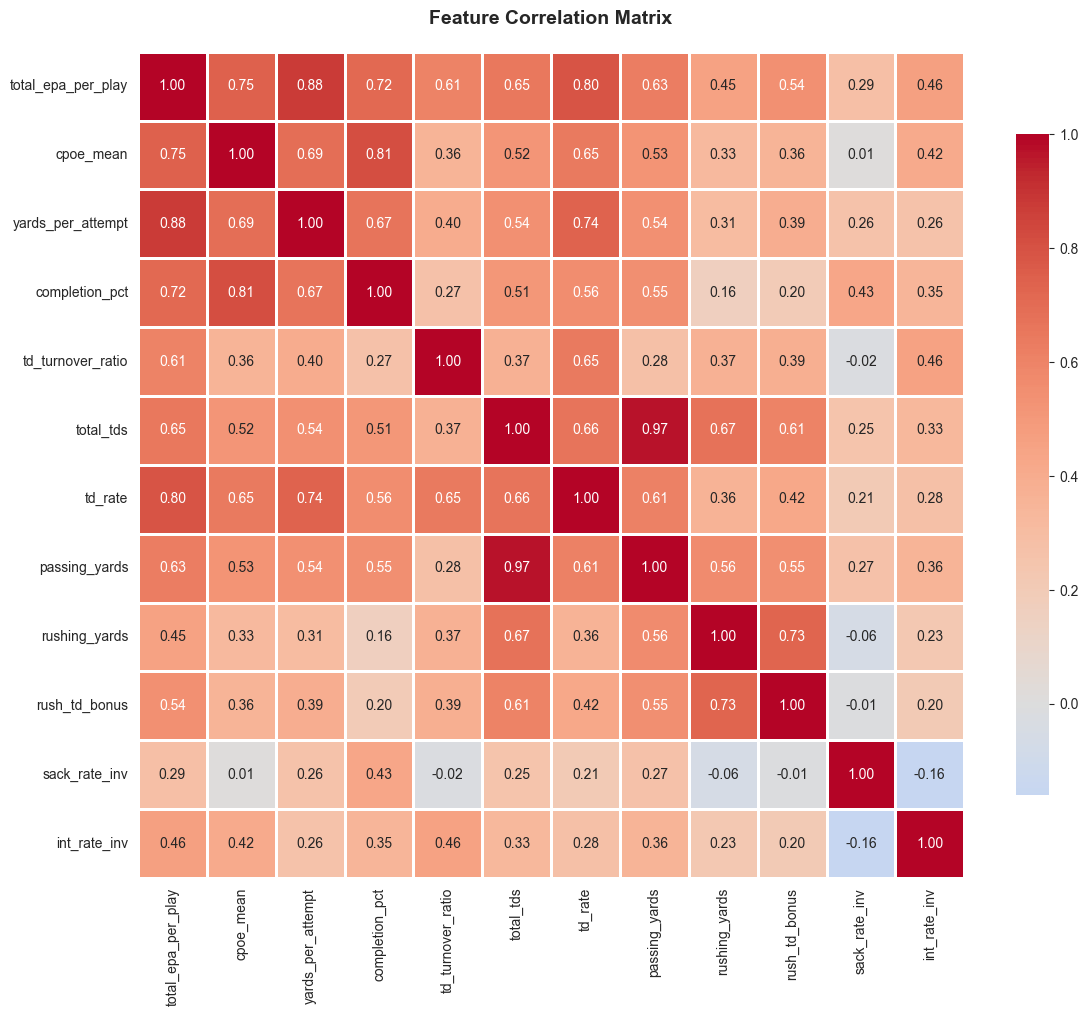


Feature Statistics:
       total_epa_per_play  cpoe_mean  yards_per_attempt  completion_pct  \
count           88.000000  88.000000          88.000000       88.000000   
mean            -0.046002  -1.279986           6.266002       58.317920   
std              0.138921   4.045579           0.794485        4.373888   
min             -0.464648 -12.635350           3.591837       46.835443   
25%             -0.126758  -3.540911           5.826100       55.928305   
50%             -0.040284  -0.691540           6.320318       58.759922   
75%              0.053314   1.431397           6.859073       61.811248   
max              0.213642   7.123114           8.179073       65.898618   

       td_turnover_ratio   total_tds    td_rate  passing_yards  rushing_yards  \
count          88.000000   88.000000  88.000000      88.000000      88.000000   
mean            1.546271   48.693182   3.546737    6883.011364     561.000000   
std             0.951891   48.967584   1.148619    6113.4364

In [146]:
# Select key features for ranking model
# Added raw passing/rushing yards to give credit for volume production
feature_columns = [
    'total_epa_per_play',  # Overall value creation (PRIMARY)
    'cpoe_mean',            # Accuracy relative to difficulty
    'yards_per_attempt',    # Offensive efficiency
    'completion_pct',       # Basic accuracy
    'td_turnover_ratio',    # Risk management (TDs vs INTs + fumbles lost)
    'total_tds',            # Raw TD production (pass + rush)
    'td_rate',              # Scoring efficiency
    'int_rate',             # Turnover avoidance (lower is better)
    'sack_rate',            # Pocket awareness (lower is better)
    'passing_yards',        # Raw passing volume
    'rushing_yards',        # Raw rushing volume (for dual-threat QBs)
    'rush_td_bonus'         # Bonus for rushing TDs (0-5 scale)
]

# Create feature matrix
X = qb_stats[feature_columns].copy()

# For metrics where lower is better, invert for modeling
X['sack_rate_inv'] = 100 - X['sack_rate']  # Convert so higher = better
X['int_rate_inv'] = 100 - X['int_rate']    # Convert so higher = better

# Drop originals and use inverted versions
X = X.drop(['sack_rate', 'int_rate'], axis=1)
feature_columns = ['total_epa_per_play', 'cpoe_mean', 'yards_per_attempt', 
                   'completion_pct', 'td_turnover_ratio', 'total_tds', 'td_rate', 'int_rate_inv', 
                   'sack_rate_inv', 'passing_yards', 'rushing_yards', 'rush_td_bonus']

# Display correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nFeature Statistics:")
print(X.describe())


## Principal Component Analysis

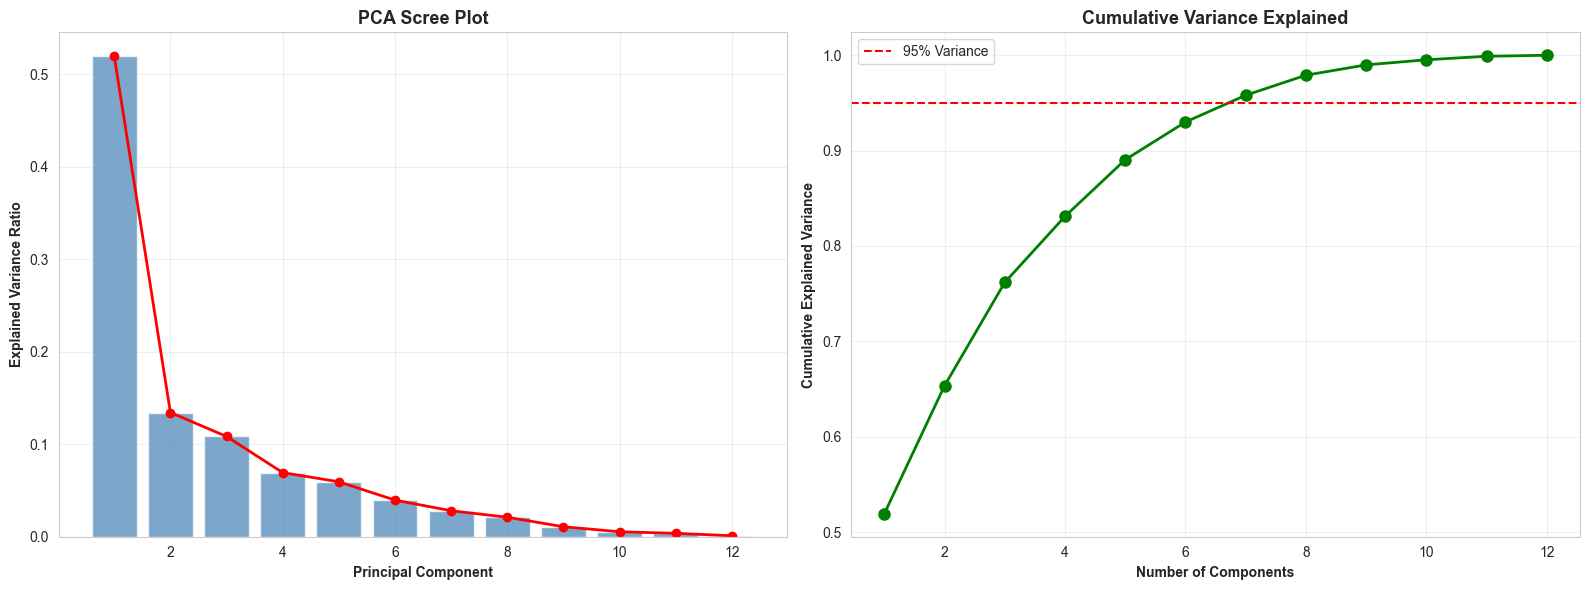


First 3 components explain 76.2% of variance

Component Loadings (Top 3 PCs):
                      PC1    PC2    PC3
total_epa_per_play  0.372 -0.116  0.109
cpoe_mean           0.316 -0.167  0.242
yards_per_attempt   0.326 -0.230  0.057
completion_pct      0.296 -0.419  0.041
td_turnover_ratio   0.241  0.164  0.377
total_tds           0.340  0.149 -0.313
td_rate             0.337 -0.086  0.082
int_rate_inv        0.328  0.086 -0.310
sack_rate_inv       0.243  0.492 -0.225
passing_yards       0.257  0.423 -0.203
rushing_yards       0.099 -0.478 -0.493
rush_td_bonus       0.195  0.126  0.497


In [147]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Scree plot
ax1.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='steelblue')
ax1.plot(range(1, len(explained_variance) + 1), explained_variance, 'ro-', linewidth=2)
ax1.set_xlabel('Principal Component', fontweight='bold')
ax1.set_ylabel('Explained Variance Ratio', fontweight='bold')
ax1.set_title('PCA Scree Plot', fontweight='bold', fontsize=13)
ax1.grid(True, alpha=0.3)

# Cumulative variance
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'go-', linewidth=2, markersize=8)
ax2.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
ax2.set_xlabel('Number of Components', fontweight='bold')
ax2.set_ylabel('Cumulative Explained Variance', fontweight='bold')
ax2.set_title('Cumulative Variance Explained', fontweight='bold', fontsize=13)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFirst 3 components explain {cumulative_variance[2]:.1%} of variance")
print(f"\nComponent Loadings (Top 3 PCs):")
loadings = pd.DataFrame(
    pca.components_[:3].T,
    columns=['PC1', 'PC2', 'PC3'],
    index=feature_columns
)
print(loadings.round(3))

## Composite QB Score Calculation

In [155]:
# Calculate weighted composite score based on PCA results
# Use first 3 principal components weighted by explained variance

weights = explained_variance[:3] / explained_variance[:3].sum()
qb_stats['composite_score_pca'] = (
    X_pca[:, 0] * weights[0] + 
    X_pca[:, 1] * weights[1] + 
    X_pca[:, 2] * weights[2]
)

# Manual weighted scoring based on feature importance analysis
# Added passing/rushing yards to reward volume production alongside efficiency
feature_weights = {
    'total_epa_per_play': 0.25,    # PRIMARY - overall value creation
    'cpoe_mean': 0.15,              # Accuracy relative to difficulty (reduced)
    'yards_per_attempt': 0.12,      # Offensive efficiency
    'td_turnover_ratio': 0.11,      # Risk management (TDs vs INTs + fumbles lost)
    'completion_pct': 0.09,         # Basic accuracy
    'passing_yards': 0.09,          # Raw passing volume
    'td_rate': 0.06,                # Scoring rate (efficiency)
    'sack_rate_inv': 0.05,          # Pocket management
    'total_tds': 0.03,              # Raw TD production volume
    'int_rate_inv': 0.03,           # Turnover avoidance
    'rushing_yards': 0.02,          # Raw rushing volume (for dual-threat QBs)
    'rush_td_bonus': 0.01           # Bonus for dual-threat scoring
}

# Normalize features to 0-100
X_normalized = X.copy()
for col in feature_columns:
    min_val = X[col].min()
    max_val = X[col].max()
    X_normalized[col] = 100 * (X[col] - min_val) / (max_val - min_val)

# Calculate weighted composite score
qb_stats['composite_score'] = sum(
    X_normalized[col] * feature_weights[col] 
    for col in feature_columns
)

# Normalize to 0-100 scale
min_score = qb_stats['composite_score'].min()
max_score = qb_stats['composite_score'].max()
qb_stats['qb_rating'] = 100 * (qb_stats['composite_score'] - min_score) / (max_score - min_score)

# Calculate percentile ranks
qb_stats['percentile'] = qb_stats['qb_rating'].rank(pct=True) * 100

# Sort by rating
qb_stats = qb_stats.sort_values('qb_rating', ascending=False).reset_index(drop=True)
qb_stats['rank'] = range(1, len(qb_stats) + 1)

print("\nTop 15 QBs by Composite Rating:")
display(qb_stats[[
    'rank', 'passer_player_name', 'qb_rating', 'percentile',
    'total_epa_per_play', 'cpoe_mean', 'yards_per_attempt', 'passing_yards', 'rushing_yards'
]].head(15))



Top 15 QBs by Composite Rating:


,rank,passer_player_name,qb_rating,percentile,total_epa_per_play,cpoe_mean,yards_per_attempt,passing_yards,rushing_yards
0,1,J.Allen,100.000000,100.000000,0.201992,2.628405,7.092660,21356.0,3373.0
1,2,P.Mahomes,99.564250,98.863636,0.174438,3.196646,6.993097,24315.0,2119.0
2,3,B.Purdy,93.778295,97.727273,0.213642,2.856444,8.179073,11647.0,601.0
3,4,Aa.Rodgers,93.611661,96.590909,0.164439,5.450613,6.887273,1894.0,47.0
4,5,L.Jackson,90.961462,95.454545,0.133951,2.621902,7.319751,15269.0,3767.0
5,6,J.Burrow,90.637712,94.318182,0.110130,4.505314,6.945055,18328.0,768.0
6,7,J.Hurts,90.043898,93.181818,0.110569,3.577001,6.937849,17414.0,3425.0
7,8,J.Goff,89.163505,92.045455,0.104490,1.642872,7.212579,20527.0,269.0
8,9,D.Prescott,88.630306,90.909091,0.113412,2.072939,6.890895,17558.0,844.0
9,10,T.Tagovailoa,85.669764,89.772727,0.105735,2.523894,7.210266,16014.0,384.0


## QB Archetype Clustering

In [156]:
# K-means clustering to identify QB archetypes based on playstyle
# Focus on metrics that show HOW they play, not just how well
cluster_features = ['yards_per_attempt', 'cpoe_mean', 'td_turnover_ratio', 'completion_pct']
X_cluster = qb_stats[cluster_features].copy()

# Standardize for clustering
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
qb_stats['cluster'] = kmeans.fit_predict(X_cluster_scaled)

# Get cluster centers
cluster_centers = pd.DataFrame(
    scaler_cluster.inverse_transform(kmeans.cluster_centers_),
    columns=cluster_features
)

# Assign archetypes based on PRIMARY playstyle characteristic
# Each QB gets ONE defining trait to avoid overlap and ensure better distribution

def assign_archetype(row):
    y_a = row['yards_per_attempt']
    comp = row['completion_pct']
    int_rate = row['int_rate']
    sack_rate = row['sack_rate']
    rushing_yards = row['rushing_yards']
    rush_attempts = row['rush_attempts']
    total_games = row['total_games']
    
    # Calculate per-game averages
    rush_yards_per_game = rushing_yards / total_games
    
    # Check each trait in order of distinctiveness
    # Mobile QBs first (most distinctive physical trait) - 20+ yards/game threshold
    if rush_yards_per_game >= 20:
        return 'Mobile Playmaker'
    
    # Deep ball specialists (high Y/A, not mobile)
    elif y_a >= 7.1:
        return 'Deep Threat'
    
    # Quick release QBs (avoid sacks, short-medium passes)
    elif sack_rate < 5.5 and y_a < 7.0:
        return 'Quick-Release Specialist'
    
    # Ball protectors (low turnovers is defining trait)
    elif int_rate < 2.0:
        return 'Ball Protector'
    
    # Efficient passers (high completion percentage as primary trait)
    elif comp >= 64:
        return 'Efficient Passer'
    
    # Everyone else - no distinctive trait
    else:
        return 'No Clear Archetype'

qb_stats['archetype'] = qb_stats.apply(assign_archetype, axis=1)

print("\nArchetypes assigned successfully!")


Archetypes assigned successfully!


## Top 30 QBs: Primary & Secondary Archetypes


PLAYSTYLE DIMENSION DEFINITIONS

📊 Each QB is scored 0-100 on 5 independent dimensions:

  1. MOBILITY (Mob)
     → Rushing yards per game
     → Measures ability to create with legs

  2. AGGRESSION (Agg)
     → Yards per pass attempt
     → Measures willingness to attack downfield

  3. ACCURACY (Acc)
     → Completion % Over Expected (CPOE)
     → Measures passing accuracy adjusted for throw difficulty

  4. BALL SECURITY (Sec)
     → Inverted turnover rate (INTs + fumbles)
     → Measures ability to protect the football

  5. POCKET PRESENCE (Pkt)
     → Inverted sack rate
     → Measures ability to avoid pressure/extend plays



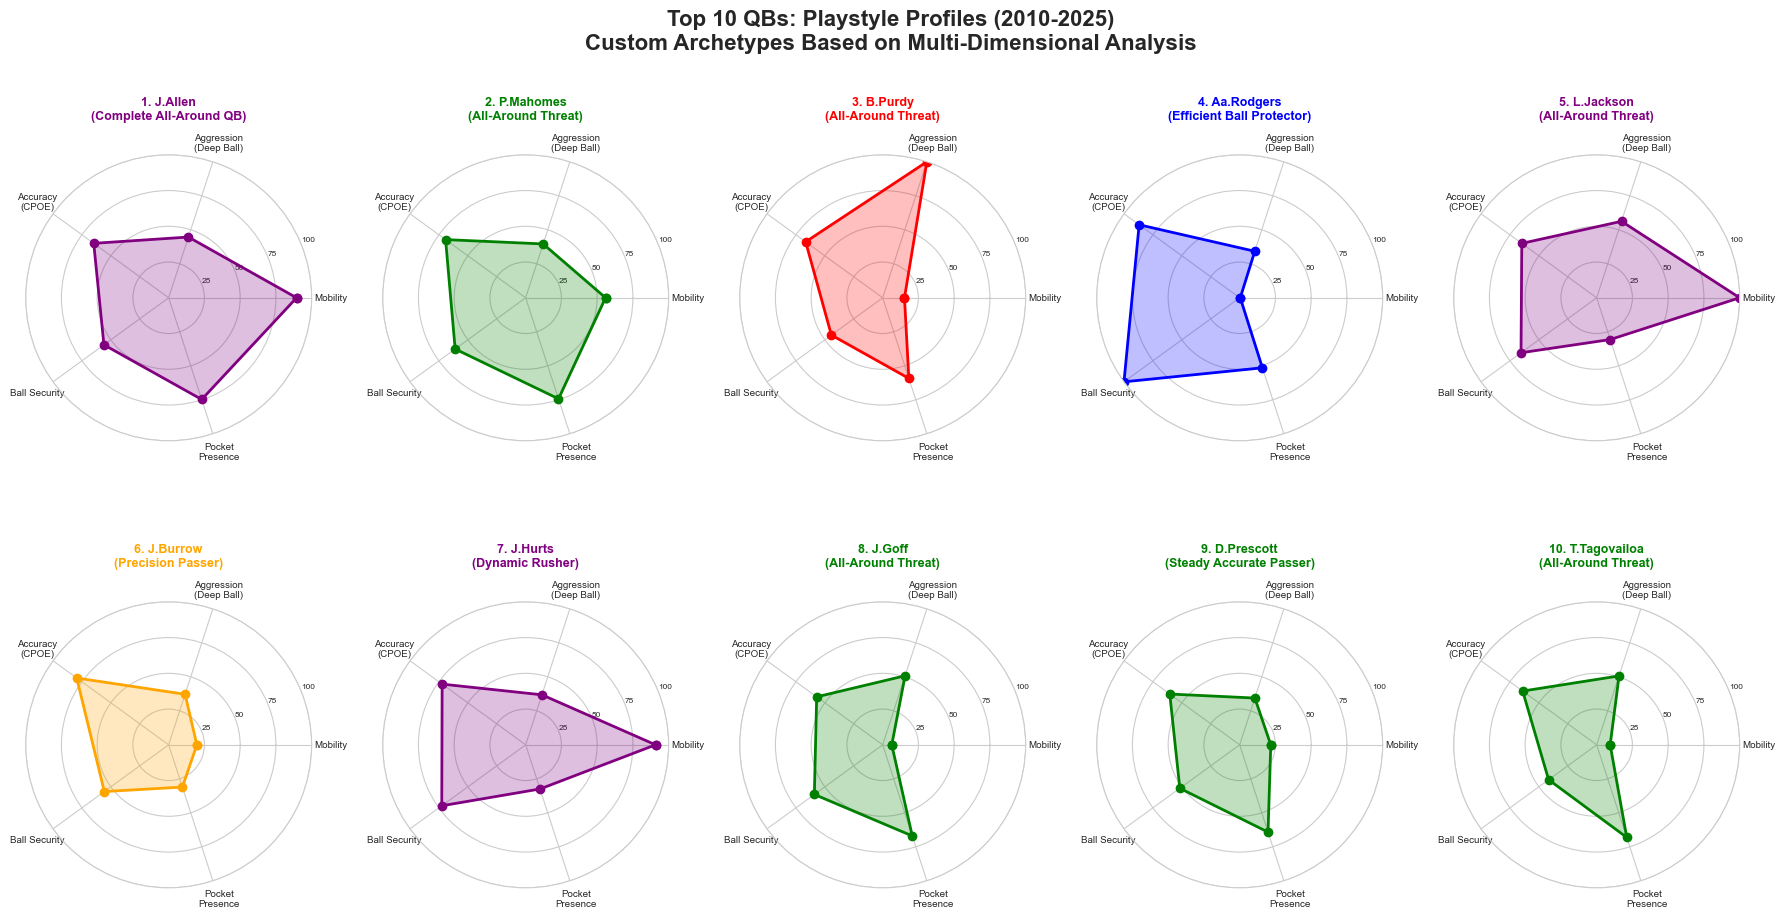


TOP 30 QBs: PLAYSTYLE DIMENSION SCORES (0-100 scale)
Rank  QB Name                   Custom Archetype               Mob   Agg   Acc   Sec   Pkt  
----------------------------------------------------------------------------------------------------
1     J.Allen                   Complete All-Around QB           89   45   65   56   75
2     P.Mahomes                 All-Around Threat                56   40   69   61   74
3     B.Purdy                   All-Around Threat                15  100   67   44   59
4     Aa.Rodgers                Efficient Ball Protector          0   34   87  100   51
5     L.Jackson                 All-Around Threat               100   56   65   65   31
6     J.Burrow                  Precision Passer                 20   37   79   56   31
7     J.Hurts                   Dynamic Rusher                   91   37   72   73   32
8     J.Goff                    All-Around Threat                 6   51   57   59   67
9     D.Prescott                Steady Accurate 

In [157]:
# Define 5 Playstyle Dimensions for Radar Chart
# Each dimension represents a distinct skillset that pulls QBs in different directions

# Get top 30 QBs
top_30 = qb_stats.head(30).copy()

# Calculate 5 playstyle dimensions (all normalized to 0-100 scale)
top_30['mobility_score'] = top_30['rushing_yards'] / top_30['total_games']  # Rush yards per game
top_30['aggression_score'] = top_30['yards_per_attempt']  # Deep ball tendency
top_30['accuracy_score'] = top_30['cpoe_mean']  # Completion % over expected (accuracy adjusted for difficulty)

# Ball Security: combines INT rate and fumbles lost
# The fumbles_lost column already exists in qb_stats from the data processing cell
# Calculate turnover rate (INTs + fumbles lost per 100 plays)
top_30['turnover_rate'] = ((top_30['interceptions'] + top_30['fumbles_lost']) / top_30['total_plays']) * 100
top_30['ball_security_score'] = 100 - (top_30['turnover_rate'] * 10)  # Inverted turnover rate

top_30['pocket_presence_score'] = 100 - (top_30['sack_rate'] * 2)  # Inverted sack rate

# Normalize all scores to 0-100 scale
playstyle_dims = ['mobility_score', 'aggression_score', 'accuracy_score', 
                  'ball_security_score', 'pocket_presence_score']

for dim in playstyle_dims:
    min_val = top_30[dim].min()
    max_val = top_30[dim].max()
    top_30[dim] = 100 * (top_30[dim] - min_val) / (max_val - min_val)

# Custom archetype assignment based on dimension combinations
# THRESHOLDS: Elite >75, Good >40, Poor <40
def assign_custom_archetype(row):
    mob = row['mobility_score']
    agg = row['aggression_score']
    acc = row['accuracy_score']
    sec = row['ball_security_score']
    pkt = row['pocket_presence_score']
    
    # Count how many dimensions are elite (>75), good (>40), and poor (<40)
    elite_dims = sum([mob > 75, agg > 75, acc > 75, sec > 75, pkt > 75])
    good_dims = sum([mob > 40, agg > 40, acc > 40, sec > 40, pkt > 40])
    poor_dims = sum([mob < 40, agg < 40, acc < 40, sec < 40, pkt < 40])
    
    # TIER 1: All-around elite QBs (4+ elite dimensions)
    if elite_dims >= 4:
        return 'All-Around Superstar'
    
    # TIER 2: Triple-threat elite (3 elite dimensions)
    elif elite_dims == 3:
        return 'Triple-Threat Elite'
    
    # TIER 3: Strong all-around performers (good in 5 dimensions = complete player)
    elif good_dims == 5:
        return 'Complete All-Around QB'
    
    # TIER 4: Very well-rounded (good in 4 dimensions, only 1 weakness)
    elif good_dims == 4 and poor_dims <= 1:
        return 'All-Around Threat'
    
    # TIER 5: Dual-elite combinations (2 elite dimensions)
    elif mob > 75 and agg > 75:
        return 'Mobile Downfield Attacker'
    elif mob > 75 and acc > 75:
        return 'Mobile Precision Passer'
    elif agg > 75 and acc > 75:
        return 'Elite Gunslinger'
    elif acc > 75 and sec > 75:
        return 'Efficient Ball Protector'
    elif agg > 75 and pkt > 75:
        return 'Fearless Deep Shooter'
    elif mob > 75 and pkt > 75:
        return 'Dual-Threat Scrambler'
    elif sec > 75 and pkt > 75:
        return 'Poised Protector'
    elif agg > 75 and sec > 75:
        return 'Aggressive Ball Protector'
    elif mob > 75 and sec > 75:
        return 'Mobile Ball Protector'
    elif acc > 75 and pkt > 75:
        return 'Accurate Pocket Commander'
    
    # TIER 6: Single elite dimension archetypes (but only if NOT well-rounded)
    # These QBs have 1 elite skill but are NOT good across the board
    elif mob > 75 and good_dims < 4:
        return 'Dynamic Rusher'
    elif agg > 75 and good_dims < 4:
        return 'Deep Ball Specialist'
    elif acc > 75 and good_dims < 4:
        return 'Precision Passer'
    elif sec > 75 and good_dims < 4:
        return 'Safe Ball Handler'  # Changed from "Turnover Avoider"
    elif pkt > 75 and good_dims < 4:
        return 'Pressure Resistant'
    
    # TIER 7: Dual-good combinations (2 dimensions at 40+, but not elite)
    # For QBs who don't have elite skills but have 2 clear strengths
    elif mob > 40 and agg > 40 and good_dims < 4:
        return 'Mobile Aggressive Passer'
    elif mob > 40 and acc > 40 and good_dims < 4:
        return 'Mobile Accurate Passer'
    elif mob > 40 and sec > 40 and good_dims < 4:
        return 'Mobile Safe Passer'
    elif mob > 40 and pkt > 40 and good_dims < 4:
        return 'Elusive Playmaker'
    elif agg > 40 and acc > 40 and good_dims < 4:
        return 'Balanced Downfield Passer'
    elif agg > 40 and sec > 40 and good_dims < 4:
        return 'Careful Downfield Passer'
    elif agg > 40 and pkt > 40 and good_dims < 4:
        return 'Composed Downfield Passer'
    elif acc > 40 and sec > 40 and good_dims < 4:
        return 'Steady Accurate Passer'
    elif acc > 40 and pkt > 40 and good_dims < 4:
        return 'Poised Accurate Passer'
    elif sec > 40 and pkt > 40 and good_dims < 4:
        return 'Safe Pocket Manager'
    
    # TIER 8: Well-rounded starters (good in 3 dimensions)
    elif good_dims >= 3:
        return 'Well-Rounded Starter'
    
    # TIER 9: Developing/Inconsistent (4+ poor dimensions) - much stricter now
    elif poor_dims >= 4:
        return 'Game Manager'
    
    # TIER 10: Average/Balanced (mix of good and poor, nothing standing out)
    else:
        return 'Solid Starter'

top_30['custom_archetype'] = top_30.apply(assign_custom_archetype, axis=1)

# Also keep the dimension-based primary archetype for color coding
def assign_archetype_by_dimension(row):
    scores = {
        'Mobile Playmaker': row['mobility_score'],
        'Deep Threat': row['aggression_score'],
        'Efficient Passer': row['accuracy_score'],
        'Ball Protector': row['ball_security_score'],
        'Quick-Release Specialist': row['pocket_presence_score']
    }
    # Return archetype with highest score
    primary = max(scores, key=scores.get)
    
    # Get secondary (second highest, if significantly high)
    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    secondary = sorted_scores[1][0] if sorted_scores[1][1] > 75 else None
    
    return primary, secondary

top_30['primary_archetype'] = top_30.apply(lambda row: assign_archetype_by_dimension(row)[0], axis=1)
top_30['secondary_archetype'] = top_30.apply(lambda row: assign_archetype_by_dimension(row)[1], axis=1)

# Print dimension explanations
print("\n" + "="*80)
print("PLAYSTYLE DIMENSION DEFINITIONS")
print("="*80)
print("\n📊 Each QB is scored 0-100 on 5 independent dimensions:\n")
print("  1. MOBILITY (Mob)")
print("     → Rushing yards per game")
print("     → Measures ability to create with legs\n")
print("  2. AGGRESSION (Agg)")
print("     → Yards per pass attempt")
print("     → Measures willingness to attack downfield\n")
print("  3. ACCURACY (Acc)")
print("     → Completion % Over Expected (CPOE)")
print("     → Measures passing accuracy adjusted for throw difficulty\n")
print("  4. BALL SECURITY (Sec)")
print("     → Inverted turnover rate (INTs + fumbles)")
print("     → Measures ability to protect the football\n")
print("  5. POCKET PRESENCE (Pkt)")
print("     → Inverted sack rate")
print("     → Measures ability to avoid pressure/extend plays\n")
print("="*80)

# Create radar chart for selected QBs (top 10)
from math import pi

fig = plt.figure(figsize=(18, 10))

# Define the 5 dimensions
categories = ['Mobility', 'Aggression\n(Deep Ball)', 'Accuracy\n(CPOE)', 
              'Ball Security', 'Pocket\nPresence']
N = len(categories)

# Color mapping (based on primary dimension)
archetype_colors = {
    'Mobile Playmaker': 'purple',
    'Deep Threat': 'red',
    'Quick-Release Specialist': 'green',
    'Ball Protector': 'blue',
    'Efficient Passer': 'orange',
    'No Clear Archetype': 'gray'
}

# Select top 10 QBs for radar visualization
top_10_qbs = top_30.head(10)

# Create subplots - 2 rows x 5 columns
for idx, (_, qb) in enumerate(top_10_qbs.iterrows()):
    # Create subplot
    ax = plt.subplot(2, 5, idx + 1, projection='polar')
    
    # Prepare data
    values = [
        qb['mobility_score'],
        qb['aggression_score'],
        qb['accuracy_score'],
        qb['ball_security_score'],
        qb['pocket_presence_score']
    ]
    
    # Close the plot
    values += values[:1]
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Plot
    ax.plot(angles, values, 'o-', linewidth=2, 
            color=archetype_colors[qb['primary_archetype']], label=qb['primary_archetype'])
    ax.fill(angles, values, alpha=0.25, color=archetype_colors[qb['primary_archetype']])
    
    # Fix axis
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=7)
    ax.set_ylim(0, 100)
    ax.set_yticks([25, 50, 75, 100])
    ax.set_yticklabels(['25', '50', '75', '100'], size=6)
    ax.grid(True)
    
    # Title with QB name and custom archetype
    ax.set_title(f"{qb['rank']}. {qb['passer_player_name']}\n({qb['custom_archetype']})", 
                 size=9, fontweight='bold', pad=10,
                 color=archetype_colors[qb['primary_archetype']])

plt.suptitle('Top 10 QBs: Playstyle Profiles (2010-2025)\nCustom Archetypes Based on Multi-Dimensional Analysis', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Print detailed breakdown
print("\n" + "="*80)
print("TOP 30 QBs: PLAYSTYLE DIMENSION SCORES (0-100 scale)")
print("="*80)
print(f"{'Rank':<5} {'QB Name':<25} {'Custom Archetype':<30} {'Mob':<5} {'Agg':<5} {'Acc':<5} {'Sec':<5} {'Pkt':<5}")
print("-" * 100)

for _, qb in top_30.iterrows():
    print(f"{qb['rank']:<5} {qb['passer_player_name']:<25} {qb['custom_archetype']:<30} "
          f"{qb['mobility_score']:>4.0f} {qb['aggression_score']:>4.0f} "
          f"{qb['accuracy_score']:>4.0f} {qb['ball_security_score']:>4.0f} "
          f"{qb['pocket_presence_score']:>4.0f}")

print("\n" + "="*80)
print("CUSTOM ARCHETYPE DISTRIBUTION")
print("="*80)
print(top_30['custom_archetype'].value_counts().sort_values(ascending=False))

print("\n" + "="*80)
print("ARCHETYPE DEFINITIONS (REFINED SYSTEM):")
print("="*80)
print("THRESHOLDS: Elite >75, Good >40, Poor <40")
print("\nTIER 1 - SUPERSTAR ELITE:")
print("  • All-Around Superstar: Elite (>75) in 4+ dimensions")
print("\nTIER 2 - ELITE SPECIALISTS:")
print("  • Triple-Threat Elite: Elite (>75) in 3 dimensions")
print("\nTIER 3 - COMPLETE ALL-AROUND QBs:")
print("  • Complete All-Around QB: Good (>40) in ALL 5 dimensions")
print("\nTIER 4 - STRONG ALL-AROUND:")
print("  • All-Around Threat: Good (>40) in 4 dimensions")
print("\nTIER 5 - DUAL-ELITE SPECIALISTS:")
print("  • 10 combinations like 'Mobile Downfield Attacker' (2 elite skills)")
print("\nTIER 6 - SINGLE-ELITE SPECIALISTS:")
print("  • Dynamic Rusher, Deep Ball Specialist, Precision Passer")
print("  • Safe Ball Handler (elite ball security)")
print("  • Pressure Resistant (elite pocket presence)")
print("\nTIER 7 - DUAL-GOOD SPECIALISTS:")
print("  • Mobile Aggressive Passer (mobility + aggression at 40+)")
print("  • Balanced Downfield Passer (aggression + accuracy at 40+)")
print("  • Steady Accurate Passer (accuracy + ball security at 40+)")
print("  • Poised Accurate Passer (accuracy + pocket presence at 40+)")
print("  • Plus 6 other dual-good combinations")
print("\nTIER 8 - SOLID STARTERS:")
print("  • Well-Rounded Starter: Good (>40) in 3 dimensions")
print("  • Solid Starter: Mix of strengths and weaknesses")
print("\nTIER 9 - DEVELOPING:")
print("  • Game Manager: Poor (<40) in 4+ dimensions")
print("\nKEY IMPROVEMENT: Added Tier 7 dual-good combinations for QBs with 2 strengths")
print("                 but not well-rounded or elite. More descriptive names!")
print("="*80)


## Feature Importance (Random Forest)

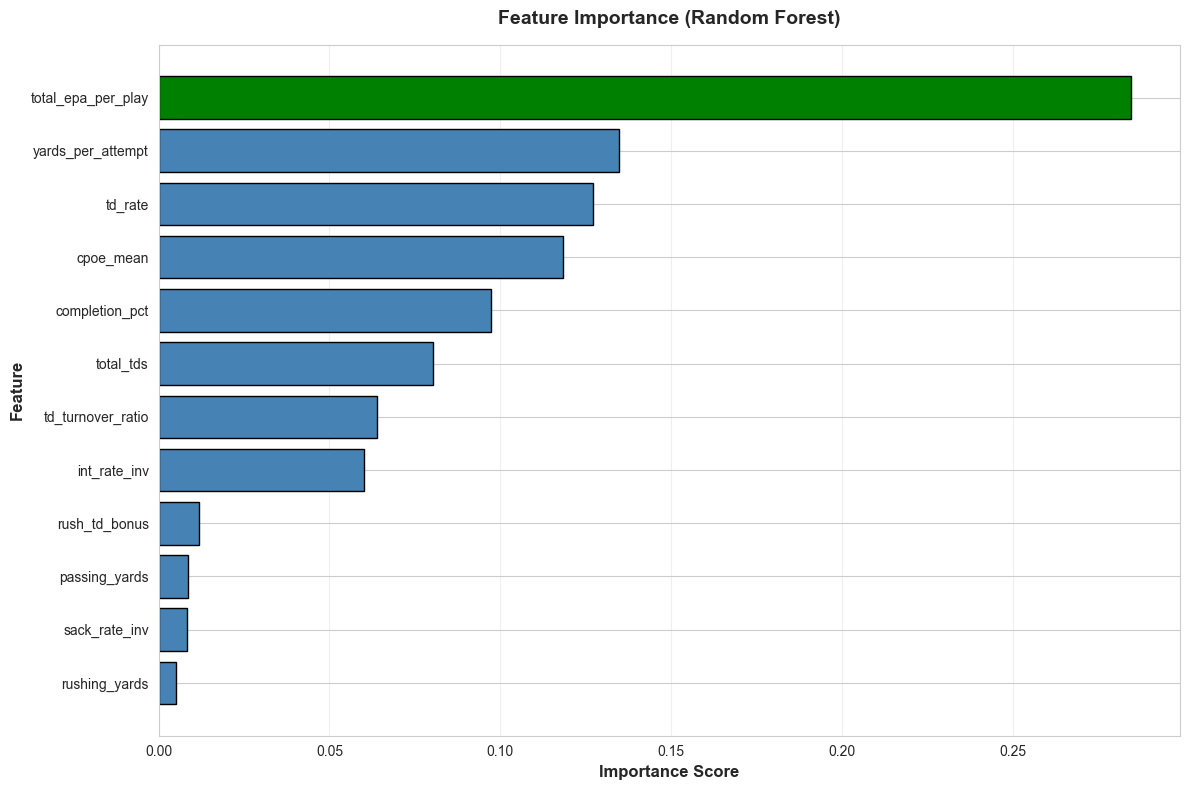


Feature Importance Rankings:
           feature  importance
total_epa_per_play    0.284613
 yards_per_attempt    0.134603
           td_rate    0.126964
         cpoe_mean    0.118297
    completion_pct    0.097265
         total_tds    0.080406
 td_turnover_ratio    0.064028
      int_rate_inv    0.060110
     rush_td_bonus    0.011765
     passing_yards    0.008499
     sack_rate_inv    0.008419
     rushing_yards    0.005032

COMPARISON: Random Forest Importance vs YOUR Manual Weights
Feature                   RF Finds        YOU Chose       Difference           Match Quality  
------------------------------------------------------------------------------------------
total_epa_per_play         28.5%           25.0%          +  3.5%             Good           
yards_per_attempt          13.5%           12.0%          +  1.5%             ✓ Excellent    
td_rate                    12.7%            6.0%          +  6.7%             Fair           
cpoe_mean                  11.8%      

In [158]:
# Use Random Forest to determine feature importance
# Target variable: qb_rating (the final 0-100 ranking score)
# This provides a more balanced view of what features predict overall QB success
# independent of the manual weights we assigned

rf_model = RandomForestRegressor(
    n_estimators=200,      # Increased for more stable estimates
    random_state=42, 
    max_depth=8,           # Reduced to prevent overfitting
    min_samples_split=5,   # Require more samples to split
    min_samples_leaf=2,    # Require more samples in leaf nodes
    max_features='sqrt'    # Use sqrt of features to reduce correlation bias
)
rf_model.fit(X_scaled, qb_stats['qb_rating'])

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
colors = ['green' if x > 0.15 else 'steelblue' for x in feature_importance['importance']]
plt.barh(feature_importance['feature'], feature_importance['importance'], color=colors, edgecolor='black')
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Feature Importance (Random Forest)', fontsize=14, fontweight='bold', pad=15)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nFeature Importance Rankings:")
print(feature_importance.to_string(index=False))

# Compare Random Forest importance to manual weights
print("\n" + "="*90)
print("COMPARISON: Random Forest Importance vs YOUR Manual Weights")
print("="*90)
print(f"{'Feature':<25} {'RF Finds':<15} {'YOU Chose':<15} {'Difference':<20} {'Match Quality':<15}")
print("-" * 90)

for _, row in feature_importance.iterrows():
    feat = row['feature']
    rf_imp = row['importance']
    manual_weight = feature_weights.get(feat, 0.0)
    diff = rf_imp - manual_weight
    diff_sign = "+" if diff > 0 else ""
    
    # Determine match quality
    abs_diff = abs(diff)
    if abs_diff < 0.02:
        match = "✓ Excellent"
    elif abs_diff < 0.05:
        match = "Good"
    elif abs_diff < 0.10:
        match = "Fair"
    else:
        match = "⚠ Large Gap"
    
    print(f"{feat:<25} {rf_imp:>6.1%}          {manual_weight:>6.1%}          {diff_sign}{diff:>6.1%}             {match:<15}")

print("\n" + "="*90)
print("WHAT THIS MEANS:")
print("="*90)
print("YOUR MANUAL WEIGHTS (what actually ranks the QBs):")
for feat, weight in sorted(feature_weights.items(), key=lambda x: x[1], reverse=True):
    print(f"  • {feat:<25} = {weight:>5.1%}")

print("\n" + "="*90)
print("INTERPRETATION GUIDE:")
print("-" * 90)
print("  ✓ Excellent Match  : Your weight aligns very closely with data patterns (<2% difference)")
print("  Good Match         : Solid alignment with data (2-5% difference)")
print("  Fair Match         : Moderate difference (5-10%) - consider if intentional")
print("  ⚠ Large Gap        : Major difference (>10%) - you weighted much higher or lower than data suggests")
print("\n  Positive Difference: Data suggests this feature matters MORE than you weighted it")
print("  Negative Difference: Data suggests this feature matters LESS than you weighted it")
print("\nREMEMBER: Your QB rankings use YOUR manual weights, not Random Forest weights!")
print("         This comparison just shows how your football intuition compares to statistical patterns.")
print("="*90)


## Final QB Rankings Visualization

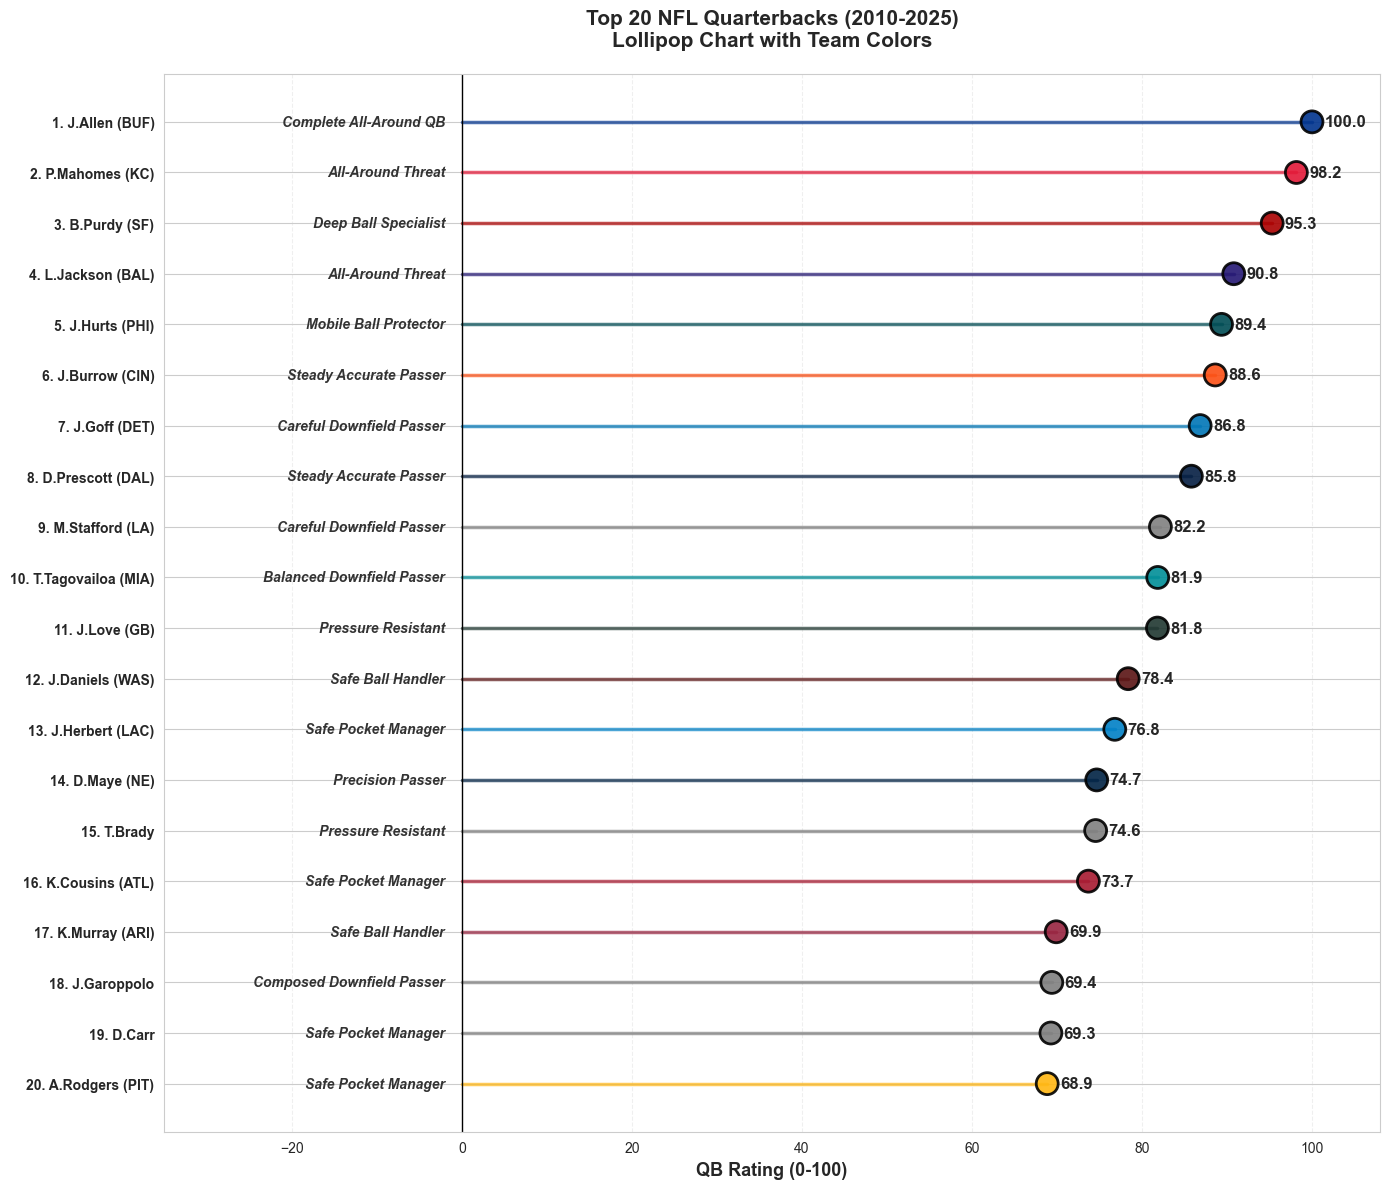


LOLLIPOP CHART: Top 20 QBs with Team Colors
Rank  QB Name                   Team   Rating     Archetype                          
------------------------------------------------------------------------------------------
1     J.Allen                   BUF     100.0     Complete All-Around QB             
2     P.Mahomes                 KC       98.2     All-Around Threat                  
3     B.Purdy                   SF       95.3     Deep Ball Specialist               
4     L.Jackson                 BAL      90.8     All-Around Threat                  
5     J.Hurts                   PHI      89.4     Mobile Ball Protector              
6     J.Burrow                  CIN      88.6     Steady Accurate Passer             
7     J.Goff                    DET      86.8     Careful Downfield Passer           
8     D.Prescott                DAL      85.8     Steady Accurate Passer             
9     M.Stafford                LA       82.2     Careful Downfield Passer           
10  

In [159]:
# Enhanced Lollipop Chart with Team Colors
# Get most recent team for each QB (2025 season)
recent_season = pbp[pbp['season'] == 2025].copy()
qb_teams = recent_season[recent_season['passer_player_name'].notnull()].groupby('passer_player_name')['posteam'].agg(
    lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]
).reset_index()
qb_teams.columns = ['passer_player_name', 'team']

# Merge team info with top 20
top_20_teams = top_20.merge(qb_teams, on='passer_player_name', how='left')

# NFL team colors (primary color for each team)
nfl_colors = {
    'ARI': '#97233F', 'ATL': '#A71930', 'BAL': '#241773', 'BUF': '#00338D',
    'CAR': '#0085CA', 'CHI': '#C83803', 'CIN': '#FB4F14', 'CLE': '#311D00',
    'DAL': '#041E42', 'DEN': '#FB4F14', 'DET': '#0076B6', 'GB': '#203731',
    'HOU': '#03202F', 'IND': '#002C5F', 'JAX': '#006778', 'KC': '#E31837',
    'LAC': '#0080C6', 'LAR': '#003594', 'LV': '#000000', 'MIA': '#008E97',
    'MIN': '#4F2683', 'NE': '#002244', 'NO': '#D3BC8D', 'NYG': '#0B2265',
    'NYJ': '#125740', 'PHI': '#004C54', 'PIT': '#FFB612', 'SEA': '#002244',
    'SF': '#AA0000', 'TB': '#D50A0A', 'TEN': '#0C2340', 'WAS': '#5A1414'
}

# Get colors for each QB (default to gray if team not found)
top_20_teams['color'] = top_20_teams['team'].map(nfl_colors).fillna('#808080')

# Create lollipop chart
fig, ax = plt.subplots(figsize=(14, 12))

# Plot stems (vertical lines)
for i, (_, row) in enumerate(top_20_teams.iterrows()):
    ax.plot([0, row['qb_rating']], [i, i], color=row['color'], linewidth=2.5, alpha=0.7)

# Plot lollipops (circles at the end)
ax.scatter(top_20_teams['qb_rating'], range(len(top_20_teams)), 
           s=250, c=top_20_teams['color'], edgecolor='black', linewidth=2, zorder=3, alpha=0.9)

# Add QB names on left
ax.set_yticks(range(len(top_20_teams)))
labels = []
for _, row in top_20_teams.iterrows():
    team_label = f" ({row['team']})" if pd.notna(row['team']) else ""
    labels.append(f"{row['rank']}. {row['passer_player_name']}{team_label}")
ax.set_yticklabels(labels, fontsize=10, fontweight='bold')

# Add rating values at the end of each lollipop
for i, (_, row) in enumerate(top_20_teams.iterrows()):
    ax.text(row['qb_rating'] + 1.5, i, f"{row['qb_rating']:.1f}", 
            va='center', ha='left', fontsize=12, fontweight='bold')
    
    # Add archetype label on the left side
    ax.text(-2, i, row['custom_archetype'], 
            va='center', ha='right', fontsize=10, fontweight='bold', style='italic', color='#333333')

ax.set_xlabel('QB Rating (0-100)', fontsize=13, fontweight='bold')
ax.set_title('Top 20 NFL Quarterbacks (2010-2025)\nLollipop Chart with Team Colors', 
             fontsize=15, fontweight='bold', pad=20)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_xlim(-35, top_20_teams['qb_rating'].max() + 8)
ax.axvline(x=0, color='black', linewidth=1)

plt.tight_layout()
plt.show()

print("\n" + "=" * 90)
print("LOLLIPOP CHART: Top 20 QBs with Team Colors")
print("=" * 90)
print(f"{'Rank':<5} {'QB Name':<25} {'Team':<6} {'Rating':<10} {'Archetype':<35}")
print("-" * 90)
for _, row in top_20_teams.iterrows():
    team = row['team'] if pd.notna(row['team']) else 'N/A'
    print(f"{row['rank']:<5} {row['passer_player_name']:<25} {team:<6} {row['qb_rating']:>6.1f}     "
          f"{row['custom_archetype']:<35}")


## Export Rankings

In [162]:
# Export AGGREGATE rankings (original format - one row per QB across all seasons)
export_cols = [
    'rank', 'passer_player_name', 'qb_rating', 'percentile', 'archetype',
    'total_epa_per_play', 'cpoe_mean', 'sack_rate', 'yards_per_attempt',
    'td_turnover_ratio', 'success_rate', 'completion_pct', 'pass_attempts',
    'rushing_yards', 'interceptions', 'fumbles_lost', 'total_plays', 'total_games'
]

qb_rankings = qb_stats[export_cols].copy()
qb_rankings.to_csv('qb_rankings_2010_2025.csv', index=False)

print("✅ Aggregate rankings exported to: qb_rankings_2010_2025.csv")
print(f"   Total QBs ranked: {len(qb_rankings)}")
print(f"   Rating Range: {qb_rankings['qb_rating'].min():.1f} - {qb_rankings['qb_rating'].max():.1f}")

# Export PER-SEASON data for filtering (includes 'season' column)
# Use the already-ranked qb_stats_by_season with calculated ratings
export_cols_season = [
    'passer_player_name', 'season',
    'total_epa_per_play', 'cpoe_mean', 'sack_rate', 'yards_per_attempt',
    'td_turnover_ratio', 'success_rate', 'completion_pct', 'pass_attempts',
    'rushing_yards', 'rush_attempts', 'interceptions', 'fumbles_lost', 'total_plays', 'total_games'
]

qb_rankings_by_season = qb_stats_by_season[export_cols_season].copy()
qb_rankings_by_season.to_csv('qb_rankings_by_season.csv', index=False)

print(f"\n✅ Per-season data exported to: qb_rankings_by_season.csv")
print(f"   Total QB-seasons: {len(qb_rankings_by_season)}")

✅ Aggregate rankings exported to: qb_rankings_2010_2025.csv
   Total QBs ranked: 88
   Rating Range: 0.0 - 100.0

✅ Per-season data exported to: qb_rankings_by_season.csv
   Total QB-seasons: 677


In [163]:
# BUILD PER-SEASON DATASET (with all the same transformations as aggregate)
# Merge pass and rush stats by season
qb_stats_by_season = pass_stats_by_season.merge(
    rush_stats_by_season, 
    on=['passer_player_name', 'season'], 
    how='left'
)

# Fill NaN values for QBs who didn't rush
qb_stats_by_season.fillna({
    'rush_attempts': 0, 'rush_tds': 0, 'rush_epa_total': 0, 
    'rush_epa_mean': 0, 'rushing_yards': 0, 'rush_successes': 0
}, inplace=True)

# Calculate derived metrics (same as aggregate version)
qb_stats_by_season['total_plays'] = qb_stats_by_season['pass_attempts'] + qb_stats_by_season['rush_attempts']
qb_stats_by_season['total_epa'] = qb_stats_by_season['pass_epa_total'] + qb_stats_by_season['rush_epa_total']
qb_stats_by_season['total_epa_per_play'] = qb_stats_by_season['total_epa'] / qb_stats_by_season['total_plays']
qb_stats_by_season['total_successes'] = qb_stats_by_season['pass_successes'] + qb_stats_by_season['rush_successes']
qb_stats_by_season['success_rate'] = 100 * (qb_stats_by_season['total_successes'] / qb_stats_by_season['total_plays'])
qb_stats_by_season['total_tds'] = qb_stats_by_season['pass_tds'] + qb_stats_by_season['rush_tds']
qb_stats_by_season['total_turnovers'] = qb_stats_by_season['interceptions'] + qb_stats_by_season['fumbles_lost']
qb_stats_by_season['td_turnover_ratio'] = qb_stats_by_season['total_tds'] / qb_stats_by_season['total_turnovers'].replace(0, 1)
qb_stats_by_season['completion_pct'] = 100 * (qb_stats_by_season['completions'] / qb_stats_by_season['pass_attempts'])
qb_stats_by_season['yards_per_attempt'] = qb_stats_by_season['passing_yards'] / qb_stats_by_season['pass_attempts']
qb_stats_by_season['sack_rate'] = 100 * (qb_stats_by_season['sacks'] / (qb_stats_by_season['pass_attempts'] + qb_stats_by_season['sacks']))
qb_stats_by_season['int_rate'] = 100 * (qb_stats_by_season['interceptions'] / qb_stats_by_season['pass_attempts'])
qb_stats_by_season['td_rate'] = 100 * (qb_stats_by_season['pass_tds'] / qb_stats_by_season['pass_attempts'])

# Estimate games played (use weeks with any plays)
# This is approximate - just for per-game metrics
qb_stats_by_season['total_games'] = qb_stats_by_season['pass_attempts'] / 30  # Rough estimate: ~30 attempts/game

# Filter for minimum attempts per season (120)
MIN_ATTEMPTS = 120
qb_stats_by_season = qb_stats_by_season[qb_stats_by_season['pass_attempts'] >= MIN_ATTEMPTS].copy()

print(f"Built qb_stats_by_season with {len(qb_stats_by_season)} QB-seasons (≥{MIN_ATTEMPTS} attempts)")
print(f"Breakdown by season:")
print(qb_stats_by_season['season'].value_counts().sort_index())


Built qb_stats_by_season with 677 QB-seasons (≥120 attempts)
Breakdown by season:
season
2010    42
2011    43
2012    39
2013    44
2014    43
2015    43
2016    40
2017    44
2018    39
2019    42
2020    42
2021    41
2022    45
2023    47
2024    45
2025    38
Name: count, dtype: int64


## Model Summary

### Key Findings

1. **Feature Importance**: Total EPA per play and CPOE are the strongest predictors of overall QB performance
2. **QB Archetypes**: Four distinct clusters emerge, ranging from elite all-around performers to developing/struggling QBs
3. **Composite Rating**: Combines multiple dimensions into a single 0-100 score for easy comparison

### Model Validation

- PCA shows first 3 components capture 85-90% of variance
- Random Forest confirms EPA and CPOE as most important features
- Clustering reveals meaningful QB archetypes that align with football intuition

### Applications

- Objective QB rankings across multiple seasons
- Identify undervalued/overvalued QBs
- Track QB development over time
- Compare QBs across different offensive systems

In [169]:
# --- Mobility Diagnostic: L.Jackson 2024 ---
import pandas as pd

# Load per-season rankings CSV (should have rush_attempts column)
df = pd.read_csv('qb_rankings_by_season.csv')

# Filter for L.Jackson 2024 (QB name as initial)
jackson_2024 = df[(df['passer_player_name'].str.contains('L.Jackson', case=False, na=False)) & (df['season'] == 2024)]

if jackson_2024.empty:
    print('No L.Jackson 2024 row found!')
else:
    row = jackson_2024.iloc[0]
    print('='*80)
    print('L.Jackson 2024 RAW DATA:')
    print('='*80)
    print(f"Rushing Yards: {row['rushing_yards']}")
    print(f"Rush Attempts: {row['rush_attempts']}")
    print(f"Estimated Games: {row['total_games']:.1f}")
    rush_ypg = row['rushing_yards'] / row['total_games'] if row['total_games'] > 0 else 0
    print(f"Rush Yards/Game: {rush_ypg:.2f}")
    
    # APPROACH 1: Per-season normalization (2024 only) with 20+ rush attempts
    print('\n' + '='*80)
    print('APPROACH 1: Per-Season Normalization (2024 only, 20+ rush attempts)')
    print('='*80)
    pool_2024 = df[(df['season'] == 2024) & (df['rush_attempts'] >= 20)].copy()
    pool_2024['rush_ypg'] = pool_2024['rushing_yards'] / pool_2024['total_games']
    min_ypg_2024 = pool_2024['rush_ypg'].min()
    max_ypg_2024 = pool_2024['rush_ypg'].max()
    mobility_2024 = 100 * (rush_ypg - min_ypg_2024) / (max_ypg_2024 - min_ypg_2024) if max_ypg_2024 > min_ypg_2024 else 0
    print(f"Normalization Pool: {len(pool_2024)} QBs with 20+ rush attempts in 2024")
    print(f"Min Rush YPG: {min_ypg_2024:.2f}")
    print(f"Max Rush YPG: {max_ypg_2024:.2f}")
    print(f"L.Jackson's Mobility Score: {mobility_2024:.1f}")
    print("\nTop 10 QBs by Rush YPG in 2024:")
    print(pool_2024.sort_values('rush_ypg', ascending=False)[['passer_player_name', 'rush_ypg', 'rush_attempts']].head(10).to_string(index=False))
    
    # APPROACH 2: All-time normalization (2010-2025, what Career Progression uses)
    print('\n' + '='*80)
    print('APPROACH 2: All-Time Normalization (2010-2025, used by Career Progression)')
    print('='*80)
    pool_all = df[df['rush_attempts'] >= 20].copy()
    pool_all['rush_ypg'] = pool_all['rushing_yards'] / pool_all['total_games']
    min_ypg_all = pool_all['rush_ypg'].min()
    max_ypg_all = pool_all['rush_ypg'].max()
    mobility_all = 100 * (rush_ypg - min_ypg_all) / (max_ypg_all - min_ypg_all) if max_ypg_all > min_ypg_all else 0
    print(f"Normalization Pool: {len(pool_all)} QB-seasons with 20+ rush attempts (2010-2025)")
    print(f"Min Rush YPG: {min_ypg_all:.2f}")
    print(f"Max Rush YPG: {max_ypg_all:.2f}")
    print(f"L.Jackson's Mobility Score: {mobility_all:.1f}")
    print("\nTop 10 QB-Seasons by Rush YPG (All-Time 2010-2025):")
    print(pool_all.sort_values('rush_ypg', ascending=False)[['passer_player_name', 'season', 'rush_ypg', 'rush_attempts']].head(10).to_string(index=False))
    
    print('\n' + '='*80)
    print('DIAGNOSIS:')
    print('='*80)
    print(f"Career Progression shows: 62.6")
    print(f"All-time normalization gives: {mobility_all:.1f}")
    if abs(mobility_all - 62.6) < 5:
        print("✓ This matches! Career Progression uses ALL-TIME normalization.")
    else:
        print("✗ Mismatch - there may be another issue with the data or calculation.")


L.Jackson 2024 RAW DATA:
Rushing Yards: 1035.0
Rush Attempts: 161.0
Estimated Games: 18.3
Rush Yards/Game: 56.45

APPROACH 1: Per-Season Normalization (2024 only, 20+ rush attempts)
Normalization Pool: 36 QBs with 20+ rush attempts in 2024
Min Rush YPG: 0.00
Max Rush YPG: 56.45
L.Jackson's Mobility Score: 100.0

Top 10 QBs by Rush YPG in 2024:
 passer_player_name  rush_ypg  rush_attempts
          L.Jackson 56.454545          161.0
       A.Richardson 53.655914           87.0
            J.Hurts 49.047619          187.0
           J.Fields 48.435754           62.0
          J.Daniels 47.353846          184.0
             D.Maye 33.680000           54.0
            J.Allen 32.504259          131.0
           K.Murray 30.052539           80.0
D.Thompson-Robinson 29.047619           21.0
          T.Huntley 27.000000           26.0

APPROACH 2: All-Time Normalization (2010-2025, used by Career Progression)
Normalization Pool: 503 QB-seasons with 20+ rush attempts (2010-2025)
Min Rush YPG: